# Model training

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from xgboost import XGBRFRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import PredefinedSplit

from sklearn.utils.class_weight import compute_sample_weight

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from imblearn.pipeline import make_pipeline as imb_make_pipeline

from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df_final = pd.read_csv("data_for_model.csv")
data = df_final.drop(columns=["Unnamed: 0", "CAMIS"])
df_final.head()

,Unnamed: 0,CAMIS,ZIPCODE,CUISINE DESCRIPTION,GRADE,ClosestWorkingTankDis,ClosestBadTankDis,BORO_Bronx,BORO_Brooklyn,BORO_Manhattan,...,BORO_Staten Island,RESULT,Pop,White,Black,Hispanic,Native,Asian,Inc,Unemp
0,0,30112340,2.801389,2.913240,3.0,0.226460,4.392523,0.0,1.0,0.0,...,0.0,0.0,2501.0,12.2,63.2,18.4,2.4,1.6,35028.0,11.5
1,1,30112340,2.801389,2.913240,2.0,0.226460,4.392523,0.0,1.0,0.0,...,0.0,0.0,2501.0,12.2,63.2,18.4,2.4,1.6,35028.0,11.5
2,2,30191841,2.831125,2.814634,3.0,0.004614,1.120030,0.0,0.0,1.0,...,0.0,0.0,5195.0,72.9,3.6,8.4,0.0,12.3,141678.0,4.7
3,3,30191841,2.831125,2.814634,3.0,0.004614,1.120030,0.0,0.0,1.0,...,0.0,0.0,5195.0,72.9,3.6,8.4,0.0,12.3,141678.0,4.7
4,4,40356018,2.868895,2.834724,3.0,0.315359,9.367778,0.0,1.0,0.0,...,0.0,0.0,2185.0,38.0,2.2,40.8,0.0,19.1,20040.0,12.2


### Convert To Binary Problem

In [3]:
data.loc[data['GRADE'] == 1, 'GRADE'] = 1
data.loc[data['GRADE'] == 2, "GRADE"] = 1
data.loc[data['GRADE'] == 3, "GRADE"] = 0
data["GRADE"].value_counts()

0.0    39922
1.0     4864
Name: GRADE, dtype: int64

In [4]:
# plt.hist(data.loc[data['GRADE'] == 1]["Asian"], color='red')
# plt.show()
# plt.hist(data.loc[data['GRADE'] == 0]["Asian"], color='green')
# plt.show()

# print("PASSING RESTAURANTS",data.loc[data['GRADE'] == 0]["Pop"].mean())

### Train Test Split and Scaling

In [5]:
dev, test = train_test_split(data, test_size=0.2, random_state=42, stratify=data["GRADE"])
train, val = train_test_split(dev, test_size = 0.2,  random_state=42)

dev_Y = dev["GRADE"].astype(int)
train_Y = train["GRADE"].astype(int)
val_Y = val["GRADE"].astype(int)
test_Y = test["GRADE"].astype(int)

dev_X = dev.drop(columns=["GRADE"])
train_X = train.drop(columns=["GRADE"])
val_X = val.drop(columns=["GRADE"])
test_X = test.drop(columns=["GRADE"])

# scaling numerical_data
scaler = StandardScaler()
dev_X[["ClosestWorkingTankDis", "ClosestBadTankDis", "Pop", "White", "Hispanic", "Black", "Native", "Asian", "Inc", "Unemp"]] = scaler.fit_transform(dev_X[["ClosestWorkingTankDis", "ClosestBadTankDis", "Pop", "White", "Hispanic", "Black", "Native", "Asian", "Inc", "Unemp"]])
train_X[["ClosestWorkingTankDis", "ClosestBadTankDis", "Pop", "White", "Hispanic", "Black", "Native", "Asian", "Inc", "Unemp"]] = scaler.fit_transform(train_X[["ClosestWorkingTankDis", "ClosestBadTankDis", "Pop", "White", "Hispanic", "Black", "Native", "Asian", "Inc", "Unemp"]])

val_X[["ClosestWorkingTankDis", "ClosestBadTankDis", "Pop", "White", "Hispanic", "Black", "Native", "Asian", "Inc", "Unemp"]] = scaler.transform(val_X[["ClosestWorkingTankDis", "ClosestBadTankDis", "Pop", "White", "Hispanic", "Black", "Native", "Asian", "Inc", "Unemp"]])
test_X[["ClosestWorkingTankDis", "ClosestBadTankDis", "Pop", "White", "Hispanic", "Black", "Native", "Asian", "Inc", "Unemp"]] = scaler.transform(test_X[["ClosestWorkingTankDis", "ClosestBadTankDis", "Pop", "White", "Hispanic", "Black", "Native", "Asian", "Inc", "Unemp"]])

dev_X.head()

,ZIPCODE,CUISINE DESCRIPTION,ClosestWorkingTankDis,ClosestBadTankDis,BORO_Bronx,BORO_Brooklyn,BORO_Manhattan,BORO_Queens,BORO_Staten Island,RESULT,Pop,White,Black,Hispanic,Native,Asian,Inc,Unemp
19196,2.876777,2.714226,0.011061,1.331296,1.0,0.0,0.0,0.0,0.0,1.0,-0.479976,-0.943447,-0.087544,1.908478,-0.264047,-0.933068,-0.857346,1.181238
15797,2.842294,2.834724,-0.358611,-0.208667,0.0,1.0,0.0,0.0,0.0,0.0,-1.202333,-0.323219,1.444511,-0.535207,-0.264047,-0.577255,-0.178274,0.356854
7215,2.731610,2.675366,0.014721,1.184310,1.0,0.0,0.0,0.0,0.0,0.0,0.083626,-1.478478,0.750376,1.934521,1.626343,-0.933068,-1.071807,1.425500
38359,2.604426,2.778831,-0.411364,0.743940,0.0,0.0,1.0,0.0,0.0,0.0,2.734736,-0.991157,-0.394946,2.294780,-0.264047,-0.752245,-0.913304,1.501832
21399,2.777661,2.804657,-0.483905,-0.776142,0.0,0.0,1.0,0.0,0.0,0.0,0.528068,1.540871,-0.627977,-0.791295,-0.264047,-0.810575,2.680585,-0.314866


### Baseline Model

ROC AUC from constant prediction model:  0.5
Average Precision from constant prediction model:  0.4712860768458951


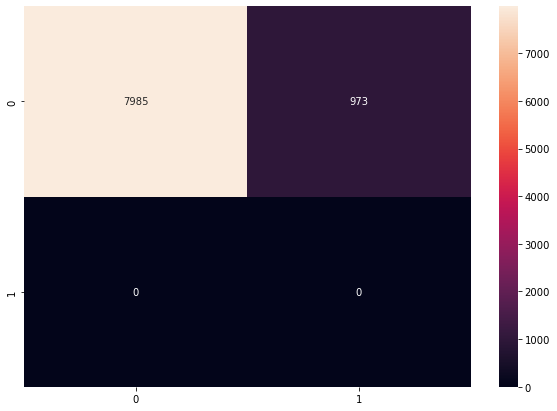

In [29]:
# Baseline model -- would just predict 3 everytime
constant_pred = np.repeat(0, test.shape[0])
base_acc = accuracy_score(constant_pred, test_Y)
# base_roc_auc = roc_auc_score(constant_pred, test_Y)
print("ROC AUC from constant prediction model: ", roc_auc_score(test_Y, constant_pred))
print("Average Precision from constant prediction model: ", f1_score(test_Y, constant_pred, average="macro"))
base_conf = confusion_matrix(constant_pred, test_Y)
plt.figure(figsize = (10,7))
sn.heatmap(base_conf, annot=True,  fmt='g')
plt.show()

### ROS

In [7]:
# resampling or other feature engineering techniques
ros = RandomOverSampler()
train_ROS = ros.fit_resample(train_X, train_Y)
train_ROS_X = train_ROS[0]
train_ROS_Y = train_ROS[1]

dev_ROS = ros.fit_resample(dev_X, dev_Y)
dev_ROS_X = dev_ROS[0]
dev_ROS_Y = dev_ROS[1]


In [8]:
# resampling or other feature engineering techniques
sm = SMOTE()
train_SMOTE = sm.fit_resample(train_X, train_Y)
train_SMOTE_X = train_SMOTE[0]
train_SMOTE_Y = train_SMOTE[1]

dev_SMOTE = sm.fit_resample(dev_X, dev_Y)
dev_SMOTE_X = dev_SMOTE[0]
dev_SMOTE_Y = dev_SMOTE[1]


### Lets see how a baseline logistic regression model does on original and sampled data

In [9]:
# Original Data
scores = cross_validate(LogisticRegression(), dev_X, dev_Y, cv=5, scoring=['roc_auc', 'average_precision'])
print("Mean AUC from 5-fold CV: ", scores['test_roc_auc'].mean())
print("Mean AP from 5-fold CV: ", scores['test_average_precision'].mean())

/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

Mean AUC from 5-fold CV:  0.6455391538679895
Mean AP from 5-fold CV:  0.17861542148634935


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [10]:
# SMOTE Data
scores = cross_validate(LogisticRegression(), dev_SMOTE_X, dev_SMOTE_Y, cv=5, scoring=['roc_auc', 'average_precision'])
print("Mean AUC from 5-fold CV: ", scores['test_roc_auc'].mean())
print("Mean AP from 5-fold CV: ", scores['test_average_precision'].mean())

/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

Mean AUC from 5-fold CV:  0.6599635003866124
Mean AP from 5-fold CV:  0.6270953314416376


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
# Random Over Sampling
scores = cross_validate(LogisticRegression(), dev_ROS_X, dev_ROS_Y, cv=5, scoring=['roc_auc', 'average_precision'])
print("Mean AUC from 5-fold CV: ", scores['test_roc_auc'].mean())
print("Mean AP from 5-fold CV: ", scores['test_average_precision'].mean())

/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

Mean AUC from 5-fold CV:  0.6501640521975665
Mean AP from 5-fold CV:  0.633410919412071


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
# Undersampling
rus = RandomUnderSampler(replacement=False, random_state=42)
pipe = imb_make_pipeline(rus, LogisticRegression())
scores = cross_validate(pipe, dev_X, dev_Y, cv=5, scoring=['roc_auc', 'average_precision'])
print("Mean AUC from 5-fold CV (Random Undersampling): ", scores['test_roc_auc'].mean())
print("Mean AP from 5-fold CV: (Random Undersampling)", scores['test_average_precision'].mean())

/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

Mean AUC from 5-fold CV (Random Undersampling):  0.6437762639514462
Mean AP from 5-fold CV: (Random Undersampling) 0.17770657741674314


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
scores = cross_validate(RandomForestClassifier(), dev_ROS_X, dev_ROS_Y, cv=5, scoring=['roc_auc', 'average_precision'])
print("Mean AUC from 5-fold CV: ", scores['test_roc_auc'].mean())
print("Mean AP from 5-fold CV: ", scores['test_average_precision'].mean())


Mean AUC from 5-fold CV:  0.9253607353803581
Mean AP from 5-fold CV:  0.8743126716241385


In [14]:
scores = cross_validate(XGBClassifier(), dev_SMOTE_X, dev_SMOTE_Y, cv=5, scoring=['roc_auc', 'average_precision'])
print("Mean AUC from 5-fold CV: ", scores['test_roc_auc'].mean())
print("Mean AP from 5-fold CV: ", scores['test_average_precision'].mean())

[11:19:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the followi

[11:19:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:19:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:19:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:19:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Mean AUC from 5-fold CV:  0.9461249297290127
Mean AP from 5-fold CV:  0.9542267173200042


It must be noted that in all of these metrics, we are performing training and validation on datasets that have already been resampled. We wanted to use this technique to simply illustrate why oversampling with XGBoost will likely yield the best ROC AUC, yet we understand that this metric is not entirely useful unless it is calculated on the test set. We expect a significant dropoff when done on the test set due to it being imbalanced and different.

In [15]:
xg_boost_model = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")

xg_boost_grid_params = {'n_estimators': np.random.randint(100,400,4), 
                        'max_depth': np.random.randint(1,10,3), 
                        "learning_rate": np.random.uniform(0.01, 0.3, 4)
}

# # Fit the random search model
grid = RandomizedSearchCV(estimator=xg_boost_model, param_distributions=xg_boost_grid_params, cv=5, scoring="roc_auc", verbose=5, n_iter=10)
grid.fit(dev_ROS_X, dev_ROS_Y)
print(f" Using a random search, the optimal parameters for the XG Boost Tree with Class Weights were found to be {grid.best_params_}, with a top val score of {grid.best_score_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/5] END learning_rate=0.27051127102080125, max_depth=5, n_estimators=222;, score=0.830 total time=   3.8s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/5] END learning_rate=0.27051127102080125, max_depth=5, n_estimators=222;, score=0.829 total time=   3.7s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/5] END learning_rate=0.27051127102080125, max_depth=5, n_estimators=222;, score=0.821 total time=   3.8s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/5] END learning_rate=0.27051127102080125, max_depth=5, n_estimators=222;, score=0.831 total time=   3.8s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 5/5] END learning_rate=0.27051127102080125, max_depth=5, n_estimators=222;, score=0.832 total time=   3.7s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/5] END learning_rate=0.13213848755032695, max_depth=5, n_estimators=343;, score=0.816 total time=   6.2s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/5] END learning_rate=0.13213848755032695, max_depth=5, n_estimators=343;, score=0.816 total time=   6.0s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/5] END learning_rate=0.13213848755032695, max_depth=5, n_estimators=343;, score=0.811 total time=   5.8s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/5] END learning_rate=0.13213848755032695, max_depth=5, n_estimators=343;, score=0.813 total time=   5.8s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 5/5] END learning_rate=0.13213848755032695, max_depth=5, n_estimators=343;, score=0.818 total time=   5.8s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/5] END learning_rate=0.22025210518385918, max_depth=8, n_estimators=257;, score=0.879 total time=   7.7s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/5] END learning_rate=0.22025210518385918, max_depth=8, n_estimators=257;, score=0.878 total time=   7.0s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/5] END learning_rate=0.22025210518385918, max_depth=8, n_estimators=257;, score=0.875 total time=   7.0s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/5] END learning_rate=0.22025210518385918, max_depth=8, n_estimators=257;, score=0.874 total time=   6.9s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 5/5] END learning_rate=0.22025210518385918, max_depth=8, n_estimators=257;, score=0.880 total time=   7.2s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/5] END learning_rate=0.15778999841364463, max_depth=8, n_estimators=222;, score=0.871 total time=   6.0s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/5] END learning_rate=0.15778999841364463, max_depth=8, n_estimators=222;, score=0.868 total time=   6.0s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/5] END learning_rate=0.15778999841364463, max_depth=8, n_estimators=222;, score=0.867 total time=   6.2s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/5] END learning_rate=0.15778999841364463, max_depth=8, n_estimators=222;, score=0.865 total time=   6.6s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 5/5] END learning_rate=0.15778999841364463, max_depth=8, n_estimators=222;, score=0.872 total time=   6.9s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/5] END learning_rate=0.13213848755032695, max_depth=8, n_estimators=293;, score=0.873 total time=   7.9s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/5] END learning_rate=0.13213848755032695, max_depth=8, n_estimators=293;, score=0.871 total time=   8.2s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/5] END learning_rate=0.13213848755032695, max_depth=8, n_estimators=293;, score=0.871 total time=   8.5s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/5] END learning_rate=0.13213848755032695, max_depth=8, n_estimators=293;, score=0.868 total time=   7.9s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 5/5] END learning_rate=0.13213848755032695, max_depth=8, n_estimators=293;, score=0.878 total time=   7.9s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/5] END learning_rate=0.15778999841364463, max_depth=3, n_estimators=343;, score=0.729 total time=   3.4s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/5] END learning_rate=0.15778999841364463, max_depth=3, n_estimators=343;, score=0.726 total time=   3.4s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/5] END learning_rate=0.15778999841364463, max_depth=3, n_estimators=343;, score=0.726 total time=   3.5s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/5] END learning_rate=0.15778999841364463, max_depth=3, n_estimators=343;, score=0.732 total time=   3.5s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 5/5] END learning_rate=0.15778999841364463, max_depth=3, n_estimators=343;, score=0.733 total time=   3.4s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/5] END learning_rate=0.15778999841364463, max_depth=3, n_estimators=222;, score=0.708 total time=   2.2s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/5] END learning_rate=0.15778999841364463, max_depth=3, n_estimators=222;, score=0.705 total time=   2.2s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/5] END learning_rate=0.15778999841364463, max_depth=3, n_estimators=222;, score=0.704 total time=   2.2s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/5] END learning_rate=0.15778999841364463, max_depth=3, n_estimators=222;, score=0.709 total time=   2.7s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 5/5] END learning_rate=0.15778999841364463, max_depth=3, n_estimators=222;, score=0.712 total time=   3.2s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/5] END learning_rate=0.22025210518385918, max_depth=5, n_estimators=222;, score=0.819 total time=   5.0s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/5] END learning_rate=0.22025210518385918, max_depth=5, n_estimators=222;, score=0.813 total time=   4.1s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/5] END learning_rate=0.22025210518385918, max_depth=5, n_estimators=222;, score=0.807 total time=   4.3s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/5] END learning_rate=0.22025210518385918, max_depth=5, n_estimators=222;, score=0.819 total time=   3.8s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 5/5] END learning_rate=0.22025210518385918, max_depth=5, n_estimators=222;, score=0.824 total time=   4.3s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/5] END learning_rate=0.15778999841364463, max_depth=3, n_estimators=257;, score=0.716 total time=   2.9s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/5] END learning_rate=0.15778999841364463, max_depth=3, n_estimators=257;, score=0.711 total time=   2.8s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/5] END learning_rate=0.15778999841364463, max_depth=3, n_estimators=257;, score=0.711 total time=   2.7s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/5] END learning_rate=0.15778999841364463, max_depth=3, n_estimators=257;, score=0.716 total time=   2.6s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 5/5] END learning_rate=0.15778999841364463, max_depth=3, n_estimators=257;, score=0.718 total time=   2.7s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/5] END learning_rate=0.15778999841364463, max_depth=5, n_estimators=343;, score=0.827 total time=   5.7s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/5] END learning_rate=0.15778999841364463, max_depth=5, n_estimators=343;, score=0.821 total time=   5.7s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/5] END learning_rate=0.15778999841364463, max_depth=5, n_estimators=343;, score=0.822 total time=   5.9s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/5] END learning_rate=0.15778999841364463, max_depth=5, n_estimators=343;, score=0.823 total time=   5.8s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 5/5] END learning_rate=0.15778999841364463, max_depth=5, n_estimators=343;, score=0.832 total time=   6.1s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


 Using a random search, the optimal parameters for the XG Boost Tree with Class Weights were found to be {'n_estimators': 257, 'max_depth': 8, 'learning_rate': 0.22025210518385918}, with a top val score of 0.8772735205591605


In [16]:
optimal_SMOTE_xg = XGBClassifier(n_estimators =230, max_depth=4, learning_rate=0.18820685685726501)
optimal_SMOTE_xg.fit(dev_SMOTE_X, dev_SMOTE_Y)
optimal_SMOTE_xg_preds = optimal_SMOTE_xg.predict(test_X)

print("Tuned Final model has ROC AUC value of: ", roc_auc_score(test_Y, optimal_SMOTE_xg_preds))
print("Tuned Final model has AP value of: ", average_precision_score(test_Y, optimal_SMOTE_xg_preds))

[11:24:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Tuned Final model has ROC AUC value of:  0.5774337288376652
Tuned Final model has AP value of:  0.13354914400428997


Final Model's confusion matrix:
XGBoost SMOTE Conf. Matrix


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


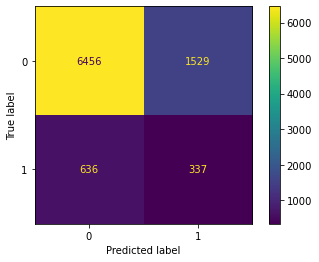

In [17]:
print("Final Model's confusion matrix:")
print("XGBoost SMOTE Conf. Matrix")
plot_confusion_matrix(optimal_SMOTE_xg, test_X, test_Y)

Feature Importance for XGBoost with Smote


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

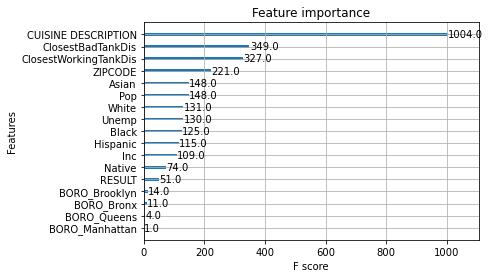

In [18]:
print("Feature Importance for XGBoost with Smote")
plot_importance(optimal_SMOTE_xg)

In [19]:
xg_pred_proba = optimal_SMOTE_xg.predict_proba(test_X)[:, 1]
model_1_fpr, model_1_tpr, _ = roc_curve(test_Y, xg_pred_proba, pos_label=1)
model_1_prec, model_1_recall, _ = precision_recall_curve(test_Y, xg_pred_proba)

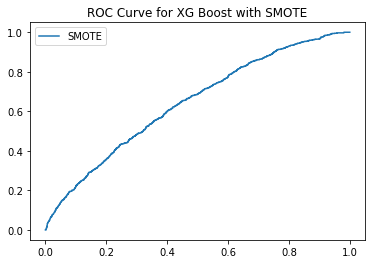

In [20]:
plt.plot(model_1_fpr, model_1_tpr, label="SMOTE")
plt.title("ROC Curve for XG Boost with SMOTE")
plt.legend()
plt.show()

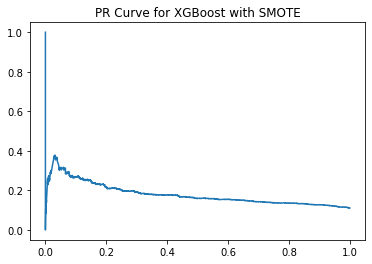

In [21]:
plt.title("PR Curve for XGBoost with SMOTE")
plt.plot(model_1_recall, model_1_prec, label="No Sampling")


Now lets see if using class weights can improve the situation...

In [22]:
xg_boost_model = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")

xg_boost_grid_params = {'n_estimators': np.random.randint(100,600,4), 
                        'max_depth': np.random.randint(1,10,3), 
                        "learning_rate": np.random.uniform(0.01, 0.3, 4),
                        "scale_pos_weight": [99]
}

# # Fit the random search model
grid = RandomizedSearchCV(estimator=xg_boost_model, param_distributions=xg_boost_grid_params, cv=5, scoring="roc_auc", verbose=5, n_iter=10)
grid.fit(dev_X, dev_Y)
print(f" Using a random search, the optimal parameters for the XG Boost Tree with Class Weights were found to be {grid.best_params_}, with a top val score of {grid.best_score_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/5] END learning_rate=0.011950348246685501, max_depth=4, n_estimators=428, scale_pos_weight=99;, score=0.645 total time=   4.1s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/5] END learning_rate=0.011950348246685501, max_depth=4, n_estimators=428, scale_pos_weight=99;, score=0.657 total time=   4.0s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/5] END learning_rate=0.011950348246685501, max_depth=4, n_estimators=428, scale_pos_weight=99;, score=0.647 total time=   4.1s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/5] END learning_rate=0.011950348246685501, max_depth=4, n_estimators=428, scale_pos_weight=99;, score=0.656 total time=   4.3s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 5/5] END learning_rate=0.011950348246685501, max_depth=4, n_estimators=428, scale_pos_weight=99;, score=0.636 total time=   5.4s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/5] END learning_rate=0.08484566800326594, max_depth=4, n_estimators=428, scale_pos_weight=99;, score=0.647 total time=   4.5s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/5] END learning_rate=0.08484566800326594, max_depth=4, n_estimators=428, scale_pos_weight=99;, score=0.654 total time=   5.9s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/5] END learning_rate=0.08484566800326594, max_depth=4, n_estimators=428, scale_pos_weight=99;, score=0.638 total time=   6.0s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/5] END learning_rate=0.08484566800326594, max_depth=4, n_estimators=428, scale_pos_weight=99;, score=0.649 total time=   5.3s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 5/5] END learning_rate=0.08484566800326594, max_depth=4, n_estimators=428, scale_pos_weight=99;, score=0.635 total time=   4.4s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/5] END learning_rate=0.19898196506771754, max_depth=4, n_estimators=428, scale_pos_weight=99;, score=0.644 total time=   3.8s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/5] END learning_rate=0.19898196506771754, max_depth=4, n_estimators=428, scale_pos_weight=99;, score=0.652 total time=   4.2s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/5] END learning_rate=0.19898196506771754, max_depth=4, n_estimators=428, scale_pos_weight=99;, score=0.629 total time=   4.0s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/5] END learning_rate=0.19898196506771754, max_depth=4, n_estimators=428, scale_pos_weight=99;, score=0.648 total time=   5.2s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 5/5] END learning_rate=0.19898196506771754, max_depth=4, n_estimators=428, scale_pos_weight=99;, score=0.644 total time=   3.9s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/5] END learning_rate=0.08484566800326594, max_depth=7, n_estimators=194, scale_pos_weight=99;, score=0.650 total time=   3.5s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/5] END learning_rate=0.08484566800326594, max_depth=7, n_estimators=194, scale_pos_weight=99;, score=0.645 total time=   3.4s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/5] END learning_rate=0.08484566800326594, max_depth=7, n_estimators=194, scale_pos_weight=99;, score=0.644 total time=   3.1s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/5] END learning_rate=0.08484566800326594, max_depth=7, n_estimators=194, scale_pos_weight=99;, score=0.658 total time=   3.1s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 5/5] END learning_rate=0.08484566800326594, max_depth=7, n_estimators=194, scale_pos_weight=99;, score=0.648 total time=   3.0s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/5] END learning_rate=0.19898196506771754, max_depth=4, n_estimators=194, scale_pos_weight=99;, score=0.640 total time=   1.8s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/5] END learning_rate=0.19898196506771754, max_depth=4, n_estimators=194, scale_pos_weight=99;, score=0.653 total time=   1.8s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/5] END learning_rate=0.19898196506771754, max_depth=4, n_estimators=194, scale_pos_weight=99;, score=0.631 total time=   1.8s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/5] END learning_rate=0.19898196506771754, max_depth=4, n_estimators=194, scale_pos_weight=99;, score=0.642 total time=   1.8s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 5/5] END learning_rate=0.19898196506771754, max_depth=4, n_estimators=194, scale_pos_weight=99;, score=0.637 total time=   1.7s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/5] END learning_rate=0.011950348246685501, max_depth=7, n_estimators=405, scale_pos_weight=99;, score=0.642 total time=   6.7s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/5] END learning_rate=0.011950348246685501, max_depth=7, n_estimators=405, scale_pos_weight=99;, score=0.649 total time=   6.9s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/5] END learning_rate=0.011950348246685501, max_depth=7, n_estimators=405, scale_pos_weight=99;, score=0.645 total time=   6.8s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/5] END learning_rate=0.011950348246685501, max_depth=7, n_estimators=405, scale_pos_weight=99;, score=0.656 total time=   6.6s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 5/5] END learning_rate=0.011950348246685501, max_depth=7, n_estimators=405, scale_pos_weight=99;, score=0.647 total time=   6.9s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/5] END learning_rate=0.13881242564347238, max_depth=7, n_estimators=405, scale_pos_weight=99;, score=0.644 total time=   6.0s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/5] END learning_rate=0.13881242564347238, max_depth=7, n_estimators=405, scale_pos_weight=99;, score=0.650 total time=   6.1s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/5] END learning_rate=0.13881242564347238, max_depth=7, n_estimators=405, scale_pos_weight=99;, score=0.640 total time=   6.6s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/5] END learning_rate=0.13881242564347238, max_depth=7, n_estimators=405, scale_pos_weight=99;, score=0.653 total time=   6.1s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 5/5] END learning_rate=0.13881242564347238, max_depth=7, n_estimators=405, scale_pos_weight=99;, score=0.650 total time=   6.1s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/5] END learning_rate=0.011950348246685501, max_depth=7, n_estimators=428, scale_pos_weight=99;, score=0.643 total time=   6.9s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/5] END learning_rate=0.011950348246685501, max_depth=7, n_estimators=428, scale_pos_weight=99;, score=0.649 total time=   6.9s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/5] END learning_rate=0.011950348246685501, max_depth=7, n_estimators=428, scale_pos_weight=99;, score=0.644 total time=   6.9s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/5] END learning_rate=0.011950348246685501, max_depth=7, n_estimators=428, scale_pos_weight=99;, score=0.656 total time=   7.3s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 5/5] END learning_rate=0.011950348246685501, max_depth=7, n_estimators=428, scale_pos_weight=99;, score=0.647 total time=   7.4s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/5] END learning_rate=0.08484566800326594, max_depth=7, n_estimators=425, scale_pos_weight=99;, score=0.654 total time=   7.6s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/5] END learning_rate=0.08484566800326594, max_depth=7, n_estimators=425, scale_pos_weight=99;, score=0.646 total time=   6.7s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/5] END learning_rate=0.08484566800326594, max_depth=7, n_estimators=425, scale_pos_weight=99;, score=0.642 total time=   6.5s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/5] END learning_rate=0.08484566800326594, max_depth=7, n_estimators=425, scale_pos_weight=99;, score=0.654 total time=   6.3s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 5/5] END learning_rate=0.08484566800326594, max_depth=7, n_estimators=425, scale_pos_weight=99;, score=0.651 total time=   6.5s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/5] END learning_rate=0.19898196506771754, max_depth=9, n_estimators=405, scale_pos_weight=99;, score=0.648 total time=   8.1s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/5] END learning_rate=0.19898196506771754, max_depth=9, n_estimators=405, scale_pos_weight=99;, score=0.641 total time=   7.9s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/5] END learning_rate=0.19898196506771754, max_depth=9, n_estimators=405, scale_pos_weight=99;, score=0.644 total time=   8.0s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/5] END learning_rate=0.19898196506771754, max_depth=9, n_estimators=405, scale_pos_weight=99;, score=0.645 total time=   8.0s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 5/5] END learning_rate=0.19898196506771754, max_depth=9, n_estimators=405, scale_pos_weight=99;, score=0.646 total time=   8.1s


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


 Using a random search, the optimal parameters for the XG Boost Tree with Class Weights were found to be {'scale_pos_weight': 99, 'n_estimators': 425, 'max_depth': 7, 'learning_rate': 0.08484566800326594}, with a top val score of 0.6493001107706753


In [23]:
optimal_weighted_xg = XGBClassifier(n_estimators =425, max_depth=7, learning_rate=0.08484566800326594, scale_pos_weight=99)
optimal_weighted_xg.fit(dev_X, dev_Y)
optimal_weighted_xg_preds = optimal_weighted_xg.predict(test_X)

print("Tuned Final model has ROC AUC value of: ", roc_auc_score(test_Y, optimal_weighted_xg_preds))
print("Tuned Final model has AP value of: ", average_precision_score(test_Y, optimal_weighted_xg_preds))

[11:28:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Tuned Final model has ROC AUC value of:  0.6045742241522999
Tuned Final model has AP value of:  0.13585643947008258


Final Model's confusion matrix:
XGBoost Weighted Conf. Matrix


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


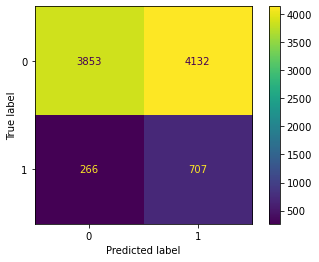

In [24]:
print("Final Model's confusion matrix:")
print("XGBoost Weighted Conf. Matrix")
plot_confusion_matrix(optimal_weighted_xg, test_X, test_Y)

Feature Importance for XGBoost with weights


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

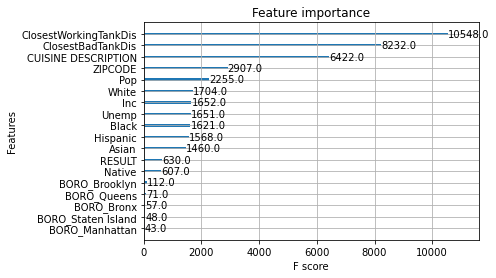

In [25]:
print("Feature Importance for XGBoost with weights")
plot_importance(optimal_weighted_xg)

In [26]:
rf_model = RandomForestClassifier(class_weight="balanced")

xg_boost_grid_params = {'n_estimators': np.random.randint(100,600,4), 
                        'max_depth': np.random.randint(1,10,3)                       
}

# # Fit the random search model
grid = RandomizedSearchCV(estimator=rf_model, param_distributions=xg_boost_grid_params, cv=5, scoring="roc_auc", verbose=5, n_iter=10)
grid.fit(dev_X, dev_Y)
print(f" Using a random search, the optimal parameters for the XG Boost Tree with Class Weights were found to be {grid.best_params_}, with a top val score of {grid.best_score_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END .....max_depth=1, n_estimators=158;, score=0.608 total time=   0.8s
[CV 2/5] END .....max_depth=1, n_estimators=158;, score=0.632 total time=   0.8s
[CV 3/5] END .....max_depth=1, n_estimators=158;, score=0.612 total time=   0.7s
[CV 4/5] END .....max_depth=1, n_estimators=158;, score=0.626 total time=   0.8s
[CV 5/5] END .....max_depth=1, n_estimators=158;, score=0.600 total time=   0.8s
[CV 1/5] END .....max_depth=1, n_estimators=405;, score=0.605 total time=   1.9s
[CV 2/5] END .....max_depth=1, n_estimators=405;, score=0.636 total time=   1.9s
[CV 3/5] END .....max_depth=1, n_estimators=405;, score=0.610 total time=   2.0s
[CV 4/5] END .....max_depth=1, n_estimators=405;, score=0.620 total time=   2.0s
[CV 5/5] END .....max_depth=1, n_estimators=405;, score=0.608 total time=   2.0s
[CV 1/5] END .....max_depth=5, n_estimators=158;, score=0.636 total time=   2.0s
[CV 2/5] END .....max_depth=5, n_estimators=158;

In [34]:
rf_weighted = RandomForestClassifier(class_weight="balanced", n_estimators =318, max_depth=7)
rf_weighted.fit(dev_X, dev_Y)
rf_weighted_preds = rf_weighted.predict(test_X)

print("Tuned Final model has ROC AUC value of: ", roc_auc_score(test_Y, rf_weighted_preds))
print("Tuned Final model has AP value of: ", average_precision_score(test_Y, rf_weighted_preds))

Tuned Final model has ROC AUC value of:  0.6207841527118227
Tuned Final model has AP value of:  0.1457528447143349


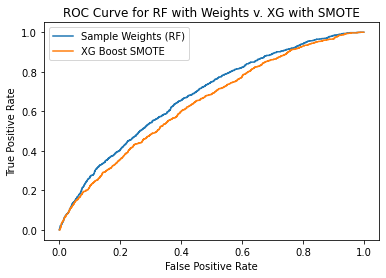

In [37]:
rf_pred_proba = rf_weighted.predict_proba(test_X)[:, 1]
model_2_fpr, model_2_tpr, _ = roc_curve(test_Y, rf_pred_proba, pos_label=1)
model_2_prec, model_2_recall, _ = precision_recall_curve(test_Y, rf_pred_proba)

plt.plot(model_2_fpr, model_2_tpr, label="Sample Weights (RF)")
plt.plot(model_1_fpr, model_1_tpr, label="XG Boost SMOTE")
plt.title("ROC Curve for RF with Weights v. XG with SMOTE")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend()
plt.show()